# Acquisition Functions
Acquisition Functions (acq. functions) are used to find the *best* next possible point to sample when doing Bayesian Optimization. The term *best* in this context depends on what the user wants to achieve. In our case we want to find the most informative point so that our surrogate model (cf. **Bayesian Optimization**). In this notebook I will introduce three acq. functions. The first one is *Expected Improvement (EI)* which is commonly used and easy to implement. After that I will discuss *Mutual Information (MI)* and *Upper Confidence Bound (UCB)*.
## Exected Improvement
### Introduction
The *EI* function is a popular choice for an acquisition function since it combines probability and magnitude of the expected improvement (see https://arxiv.org/abs/1012.2599, Chapter 2.3.1) that a possible sample point yields. Note that in is original form this is a myopic (1-step ahaed) optimization which can be done recursively to obtain a multistep ahead optimization. Since this gets very expensive https://link.springer.com/article/10.1007/BF01099263 argued to use the following improvement function
\begin{equation*}
I(x) = \max(0,f_{t+1}(x)-f(x^+))
\end{equation*}
where $f(x^+)$ is the best observed value so far. The improvement is either $0$ if the predicted value $f_{t+1}(x)$ is smaller than the best observed or the difference between the two. The new sample point is found by maximizing over all possible inputs given the already observed data $D_t = \{x_i,y_i\}$.
\begin{equation*}
x = \underset{x}{\mathrm{argmax}}\mathbb{E}(\max(0,f_{t+1}(x)-f(x^+))|D_t)
\end{equation*}
An analytical expression is derived by https://link.springer.com/article/10.1007/BF01099263 and https://arxiv.org/abs/1012.2599:
\begin{equation*}
EI (x) =\begin{cases}
    (\mu(x) - f(x^+))\Phi(Z)+\sigma(x)\phi(Z)), & \text{if $\sigma(x)>0$}\\
    0, & \text{if $\sigma(x)=0$}
  \end{cases}
\end{equation*}
where $\Phi(.)$ and $\phi(.)$ denote the *CDF* and *PDF* respectively of the standard normal distribution. The term $Z$ abbreviates
\begin{equation*}
Z = \frac{\mu(x) - f(x^+)}{\sigma(x)}
\end{equation*}
### Exploration vs Exploitation
The function can be extended to include a trade-off exploration vs exploitation by inserting an additional parameter $\zeta \geq 0$ into the equation 
\begin{equation*}
EI (x) =\begin{cases}
    (\mu(x) - f(x^+) - \zeta)\Phi(Z)+\sigma(x)\phi(Z)), & \text{if $\sigma(x)>0$}\\
    0, & \text{if $\sigma(x)=0$}
  \end{cases}
\end{equation*}
and 
\begin{equation*}
Z = \frac{\mu(x) - f(x^+) - \zeta}{\sigma(x)}
\end{equation*}
This enables the user to favour points that have a high surrogate mean (exploit) or high surogate variance (explore). Introducing this parameter changes $I(x)$ since the mean has to be higher the higher the value of $\zeta$. Therefore higher $\zeta$ lead to a more explorative behaviour and vice versa. https://dl.acm.org/citation.cfm?id=1626686 suggests a value of $\zeta = 0.01$ which works very well in a lot of cases. Suprisingly favouring exploration early and then decreasing the value $\zeta$ does not work well empirically and only slightly increases performance on short runs ($t < 30$).

The following code shows an implemtation of *EI* using *GPFlow* by creating a data set drawn from a kernel and then applying *EI* recursively for *10* runs. 

In [1]:
import utils
import acqfunctions as acq
import gpflow
import numpy as np
import matplotlib
#import math
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
fontsize_label = 24
fontsize_legend = 20
fontsize_ticks = 20
fontsize_title = 24
linewidth = 2.4
markeredgewidth = 3
markersize = 15 
matplotlib.rcParams['figure.figsize'] = (16, 8)

Now create a data set by drawing from a *RBF* kernel. After that *5* random points are chosen as trainig samples for a GP. The posterior together with the ground truth as well as the observed data points are marked to show how a GP posterior conditioned on randomly selected samples looks like.

In [3]:
# Generate data
np.random.seed(9)
# Set some parameters
f = 0.5
N = 6.
lengthscale = 0.4
num_Functions = 1
num = 100
# Build data sets
X = np.linspace(0., N, num).reshape(num, 1)
k = gpflow.kernels.RBF(1, lengthscales=lengthscale)
Y_true = utils.drawRandomFunction(k, X, num_Functions) 

size = 2
np.random.seed(57)
index = np.random.choice(range(len(X)), size=size, replace=False)
X_sample = X[index]
Y_sample = Y_true[index]

[[3.15151515]
 [1.03030303]]
[[-0.27832022]
 [ 1.01573088]]


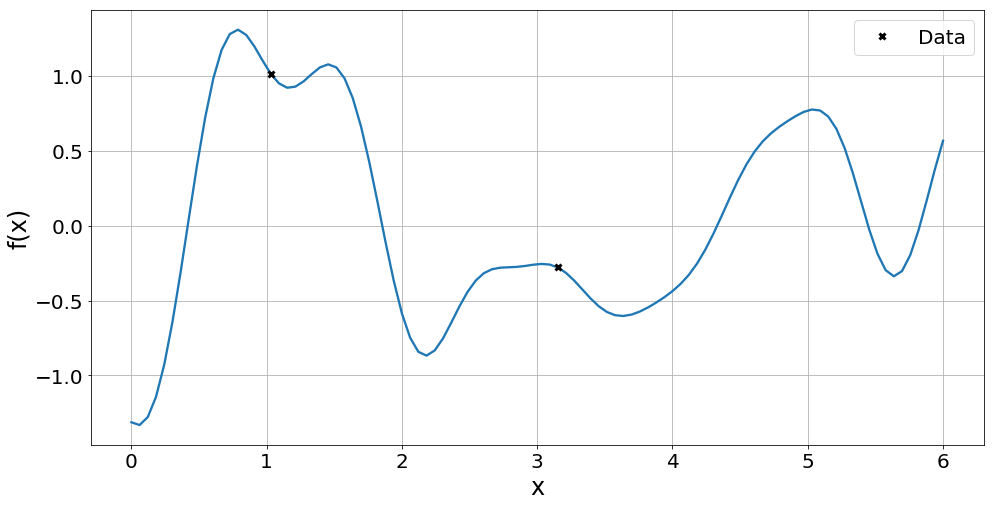

In [4]:
print(X_sample)
print(Y_sample)
# Plot ground truth and training set
fig = utils.plot2D(None, None, X, [X, Y_true, ''], [X_sample, Y_sample, 'Data', 'kx'])

In [ ]:
# Change noise parameter
sigma_n = 0.0
# Construct models with initial guess
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
m.likelihood.variance = sigma_n
m.compile()
# Print out model
m

In [ ]:
gpflow.train.ScipyOptimizer().minimize(m)
m

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.248343
  Number of iterations: 17
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.248343
  Number of iterations: 17
  Number of functions evaluations: 21


In [ ]:
# Predict with model
mean, var = m.predict_y(X)

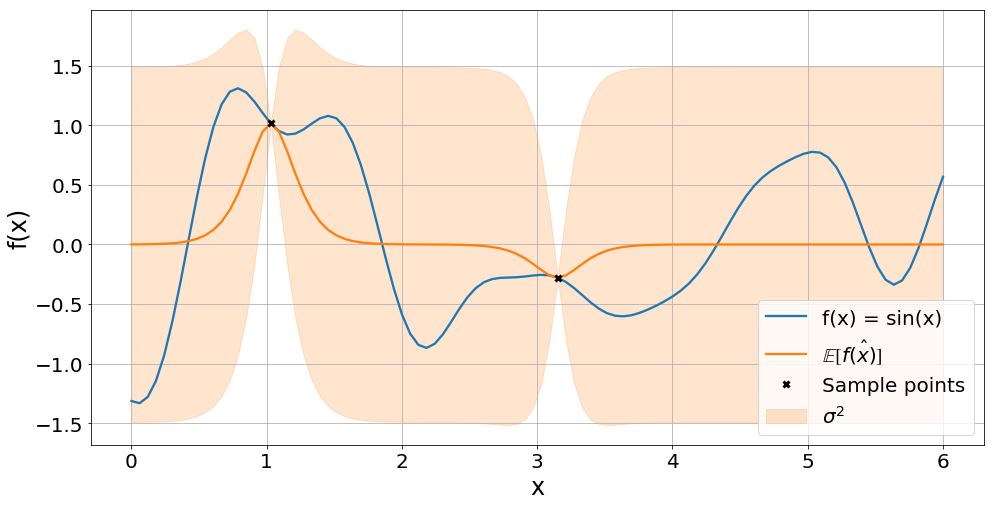

In [ ]:
# Plot posterior
fig = utils.plot2D(mean, var, X, [X, Y_true, 'f(x) = sin(x)'], [X, mean, '$\mathbb{E[}\hat{f(x)}\mathbb{]}$'], [X_sample, Y_sample, 'Sample points', 'kx'])

Define a function to conveniently plot the ground truth, the observed data as well as mean, variance (posterior) and the acquisition function for given arguments. The function can also plot multiple acquisition functions to compare their choice of the next optimal point.
After that plot the best possible choice for the next sample point according to *EI*.

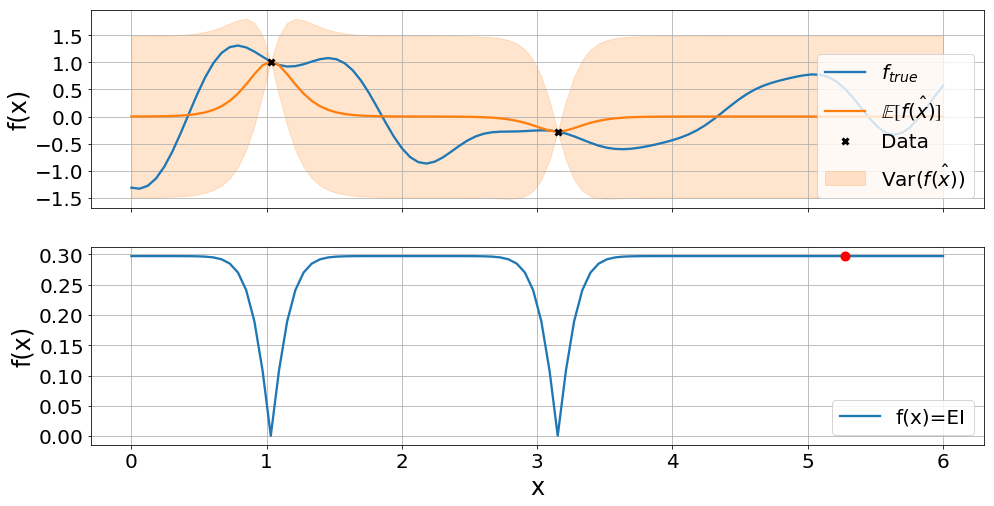

In [ ]:
ei = acq.get_EI(mean, var, np.max(Y_sample), zeta=0.0)
utils.plot_Acq(mean, var, X, Y_true, X_sample, Y_sample, True, [X, ei, 'f(x)=EI', False])

As you can see the expected improvement is zero at the already observed points sind we assume absence of noise in the observations. Also typical for *EI* is the choice of points on the borders of the input space. This intuitively is a waste of space since values outside the input space are usually less or not relevant for the task.

Now start with 2 inital points randomly chosen from a *RBF(l=0.4)* kernel as training set. After that optimize the hyperparameters according to the set, predict the posterior and use the predictions mean and variance to compute the best possible point according to *EI*. This is done recursively for $N=10$ times and output is plotted. 

Note that optimization is done with regard to only the kernels variance. All the other parameters are fixed and also the the kernel the same kind as the ground truth.

In [ ]:
# Set some parameters
k = gpflow.kernels.RBF(1, lengthscales=lengthscale)
N_samples = 10
sigma_n = 0.0

# Assume some initial samples
size = 2
np.random.seed(55)
index = np.random.choice(range(len(X)), size=size, replace=False)
X_sample = X[index]
Y_sample = Y_true[index]

# Compute EI
for i in range(N_samples):
    print('Iteration=' + str(i+1) + "/" + str(N_samples))
    # Estimate model on samples
    m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
    m.likelihood.variance = sigma_n
    m.kern.lengthscales.trainable = False
    m.likelihood.variance.trainable = False
    m.compile()
#     print(m)
    gpflow.train.ScipyOptimizer().minimize(m)
    
    # Predict with model
    mean, var = m.predict_y(X)
    
    # Calculate EI
    ei = acq.get_EI(mean, var, np.max(Y_sample), zeta=0.0)
    
    # Plot
    utils.plot_Acq(mean, var, X, Y_true, X_sample, Y_sample, True, [X, ei, 'f(x)=EI', False])
    
    # Append new point
    X_sample = np.append(X_sample, [X[np.argmax(ei)]], axis=0)
    Y_sample = np.append(Y_sample, [Y_true[np.argmax(ei)]], axis=0)

Usually, when used in the context of optimization this function should choose more points close to a local or global maximum and thus the distance should decrease. Also important is the already mentioned absence of noise which forces the GP to pass all observed data points which in real life scenarios is unrealistic.

In [ ]:
utils.plot_convergence(X_sample, Y_sample)

## 2D Experiment

[[8 5]
 [0 2]]
X_sample=[[ 2.33333333  0.33333333]
 [-3.         -1.66666667]]
Y_sample=[[-0.73460412]
 [ 0.06986689]]


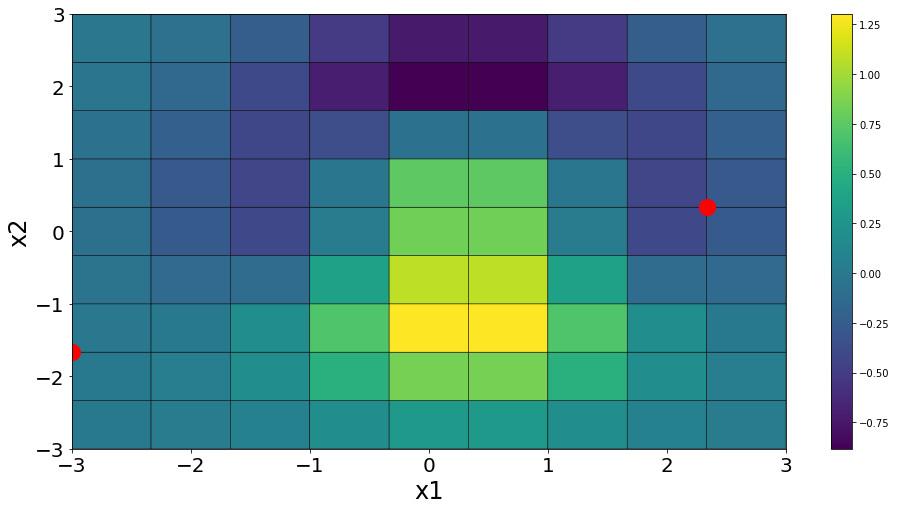

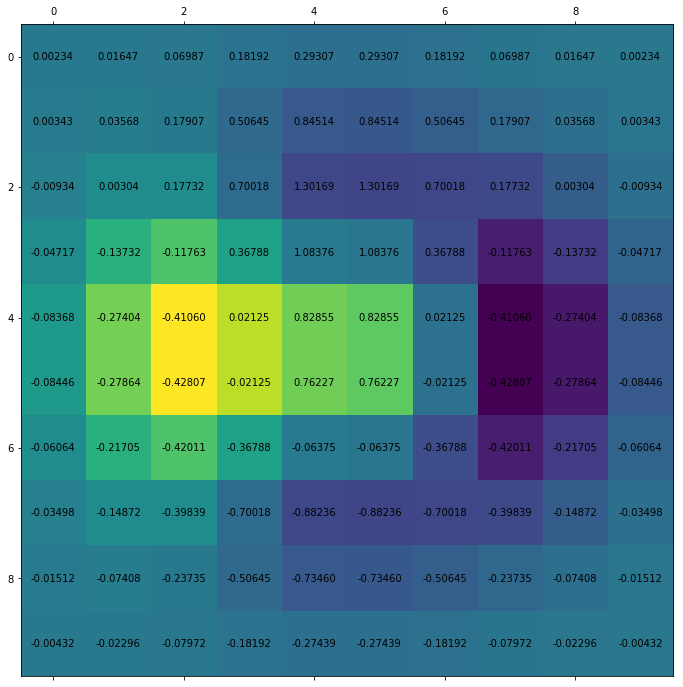

In [3]:
def f(x,y):
    return (1-(x**2+y**3)) * np.exp(-(x**2+y**2)/2)


markersize = 12
num = 10
# Generate data
bound = 3.
x1 = np.linspace(-bound, bound, num)
x2 = np.linspace(-bound, bound, num)
x1_mesh,x2_mesh = np.meshgrid(x1, x2)
X = np.dstack([x1_mesh, x2_mesh]).reshape(-1, 2)
z = f(x1_mesh, x2_mesh) # evaluation of the function on the grid
# Draw samples from feature vectors and function by a given index
size = 2
np.random.seed(7)
index = np.random.choice(range(len(x1)), size=(size,X.ndim), replace=False)
print(index)
samples = utils.sampleFeature([x1,x2], index)
X1_sample = samples[0]
X2_sample = samples[1]  
X_sample = np.column_stack((X1_sample, X2_sample))
Y_sample = utils.samplefromFunc(f=z, ind=index)

# Plot ground truth and samples
cbar = plt.pcolor(x1, x2, z, edgecolors='k', linewidths=0.5)
plt.colorbar(cbar)
for r in range(len(index)):
    plt.plot(x1[index[r][0]], x2[index[r][1]],marker='.', color='r', linestyle='none', markersize=markersize+20)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('x1', fontsize=fontsize_label)
plt.ylabel('x2', fontsize=fontsize_label)
ax = plt.gca()
ax.set_xlim(-bound, bound)
ax.set_ylim(-bound, bound)

print("X_sample="+str(X_sample))
print("Y_sample="+str(Y_sample))


fig = plt.figure(figsize=(18, 12))
ax = plt.gca()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(z.T, cmap=cm.viridis)

for (i, j), val in np.ndenumerate(z):
    ax.text(j, i, '{:0.5f}'.format(val), ha='center', va='center')

plt.show()

In [4]:
# def sampleFeature(lst, f,  size):
#     '''
#     Draw 'size' samples from a list of feature vectors and the corresponding function. 
#     For each array(feature) in lst select 'size' random indices.
    
#     Parameters:
#     lst:  	List that holds the feature vectors of type np.array
#     f:		Function 
#     size: 	Number of samples to draw from each feature
    
#     Return:
#     x: 	List of samples from each feature vector
#     y: 	List of samples from function vector
#     '''

#     x = []
#     y = []
#     for i in range(len(lst)):
#         indices = []
#         #for d in range(len(lst)): # For every feature select samples indices
#         indices.append(np.random.choice(range(len(lst[i])), size=size, replace=False))
#         ind = np.asarray(indices)
#         print(ind)
#         x.append(lst[i][ind])
# #         print(lst[i][ind])
#         y.append(f[tuple(np.split(ind,f.ndim, axis=1))]) 
# #         print(np.split(ind,f.ndim, axis=1))
# #         print(tuple(np.split(ind,f.ndim, axis=1)))
#         print(f[tuple(np.split(ind,f.ndim, axis=1))])  
#         print("-------------------------------------")
#     return np.asarray(x).reshape(-1,len(lst)), np.asarray(y).reshape(-1,len(lst))

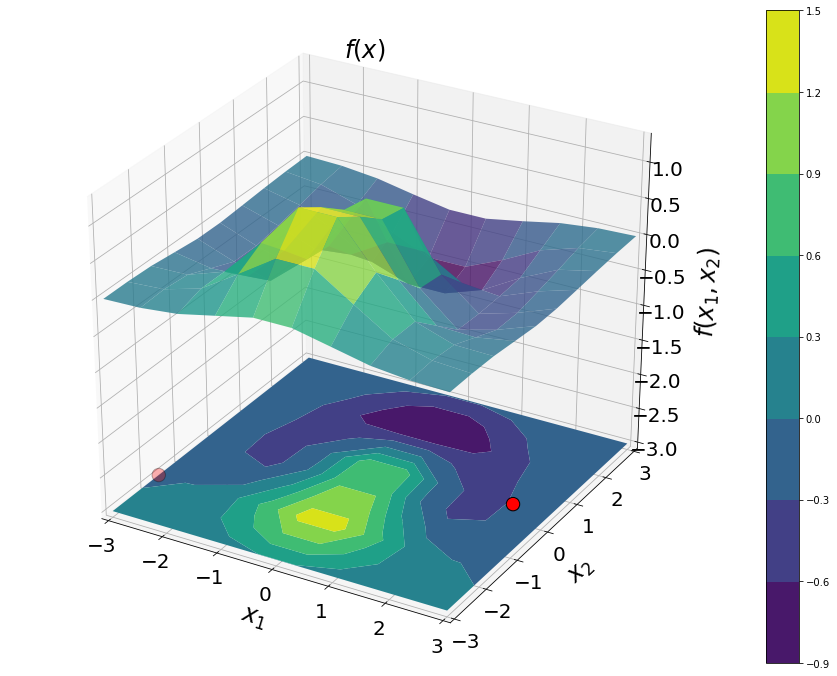

In [5]:
offset = -3.
utils.plot3D(x1_mesh, x2_mesh, z, X_sample[:,0], X_sample[:,1], offset, bound, markersize=180)

In [6]:
# Change noise parameter
sigma_n = 0.0
# Construct models with initial guess
k = gpflow.kernels.RBF(2,active_dims=[0,1], lengthscales=1.0,ARD=True)
m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
m.likelihood.variance = sigma_n
m.compile()
# Print out model
m

In [7]:
gpflow.train.ScipyOptimizer().minimize(m)
m

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.536888
  Number of iterations: 4
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.536888
  Number of iterations: 4
  Number of functions evaluations: 6


In [8]:
mean, var = m.predict_y(X)
mean_square = mean.reshape(x1_mesh.shape) # Shape: (num,num)
var_square = var.reshape(x1_mesh.shape) # Shape: (num,num)

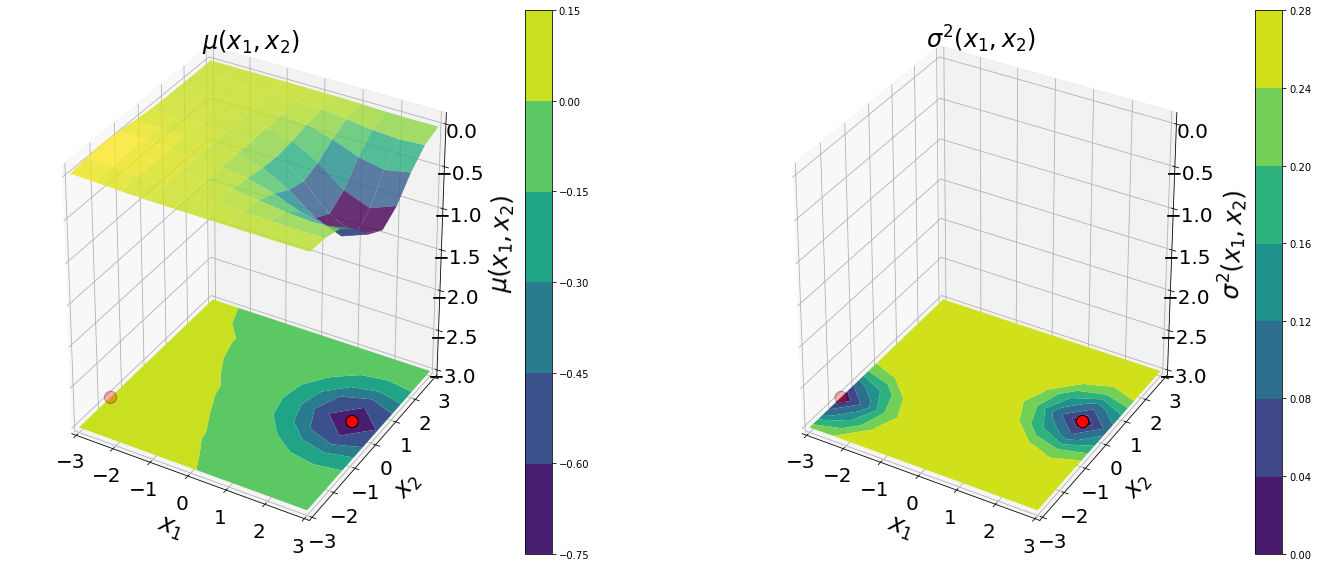

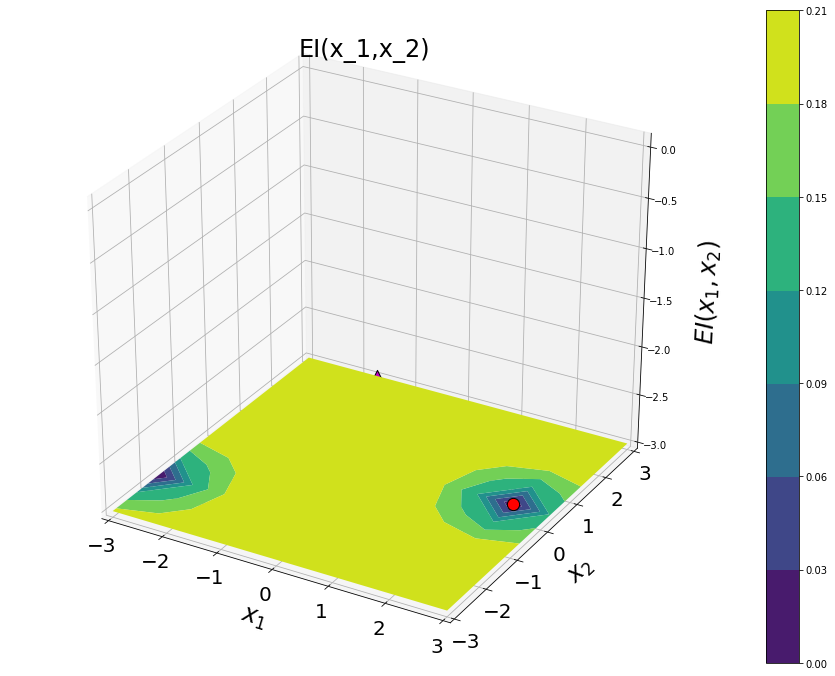

In [9]:
ei = acq.get_EI(mean, var, np.max(Y_sample), zeta=0.0)
ei_square = ei.reshape(x1_mesh.shape)
utils.plotAcq3D(mean_square, var_square, x1_mesh, x2_mesh, X_sample, bound, True, [ei_square, 'EI(x_1,x_2)'])

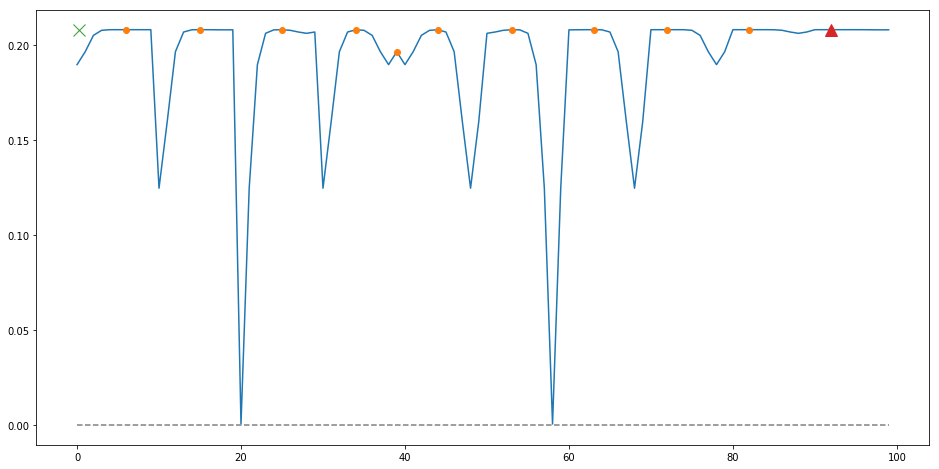

0.20816314252449894
0.20816314252449894


In [10]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(ei.reshape(-1), distance=5)
plt.plot(ei.reshape(-1))
plt.plot(peaks, ei.reshape(-1)[peaks], ".", markersize=markersize)
plt.plot(ei.reshape(-1)[np.argmax(ei.reshape(-1))], np.max(ei.reshape(-1)), "x", markersize=markersize)
#plt.ylim(bottom=0.2130, top=0.2132)
#plt.xlim(left=0, right=10)

plt.plot(np.zeros_like(ei.reshape(-1)), "--", color="gray")
plt.plot(peaks[np.argmax(ei.reshape(-1)[peaks])], np.max(ei.reshape(-1)[peaks]), "^", markersize=markersize)
plt.show()
print(np.max(ei.reshape(-1)[peaks]))
print(np.max(ei.reshape(-1)))

Iterartion=1


Time needed for calculating EI=0.6708307266235352


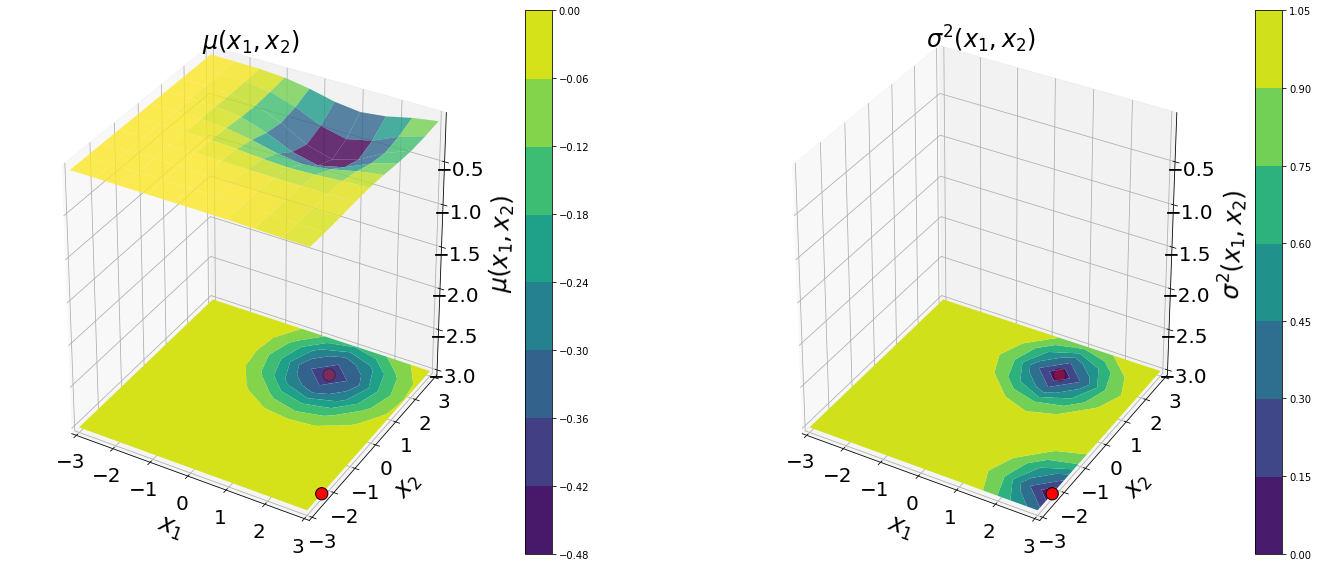

Time needed for plotting=1.263538122177124
Overall time needed=1.934678554534912
Iterartion=2
Time needed for calculating EI=0.5636112689971924


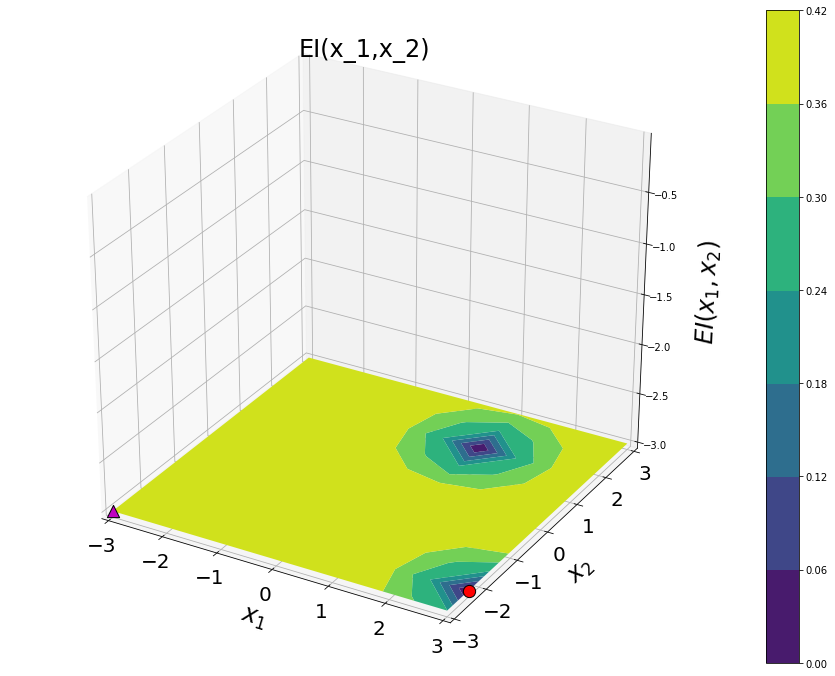

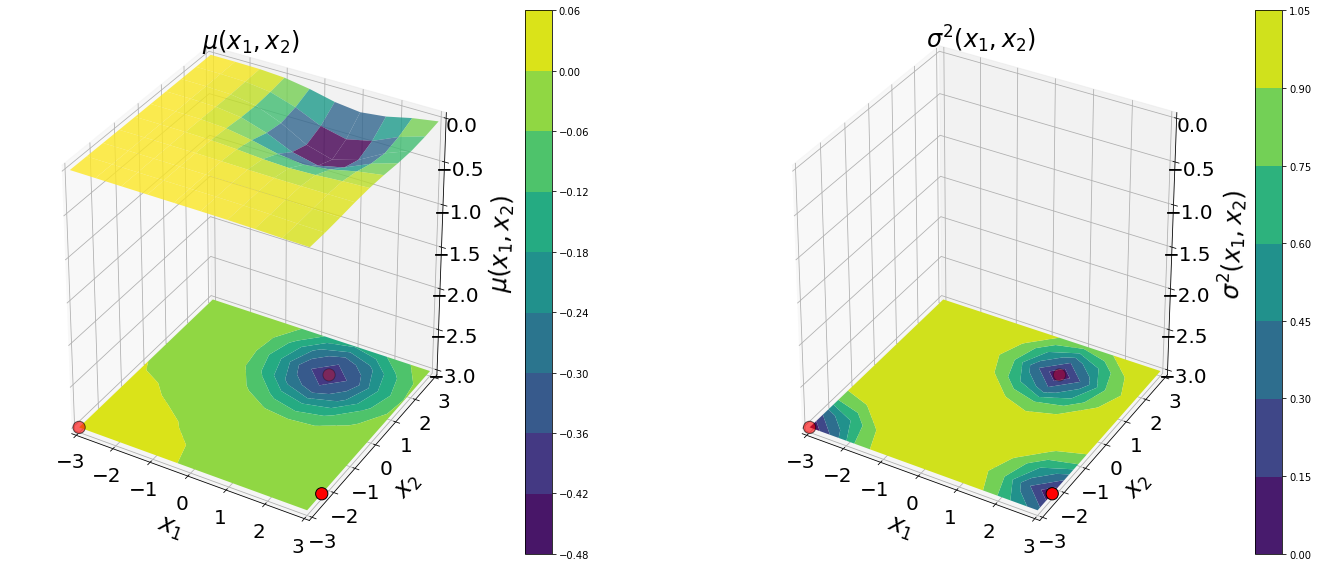

Time needed for plotting=1.8644263744354248
Overall time needed=2.4283738136291504
Iterartion=3
Time needed for calculating EI=0.7318174839019775


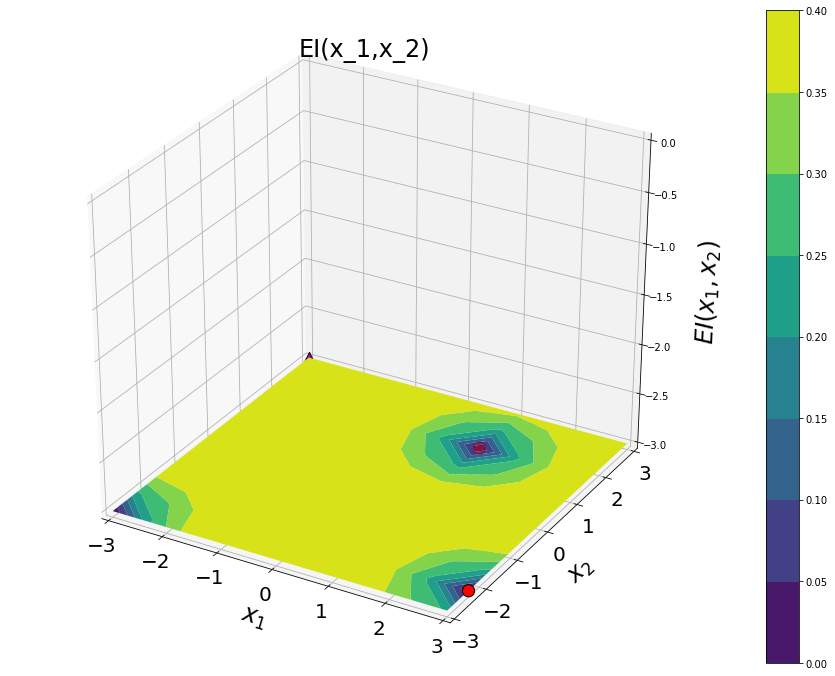

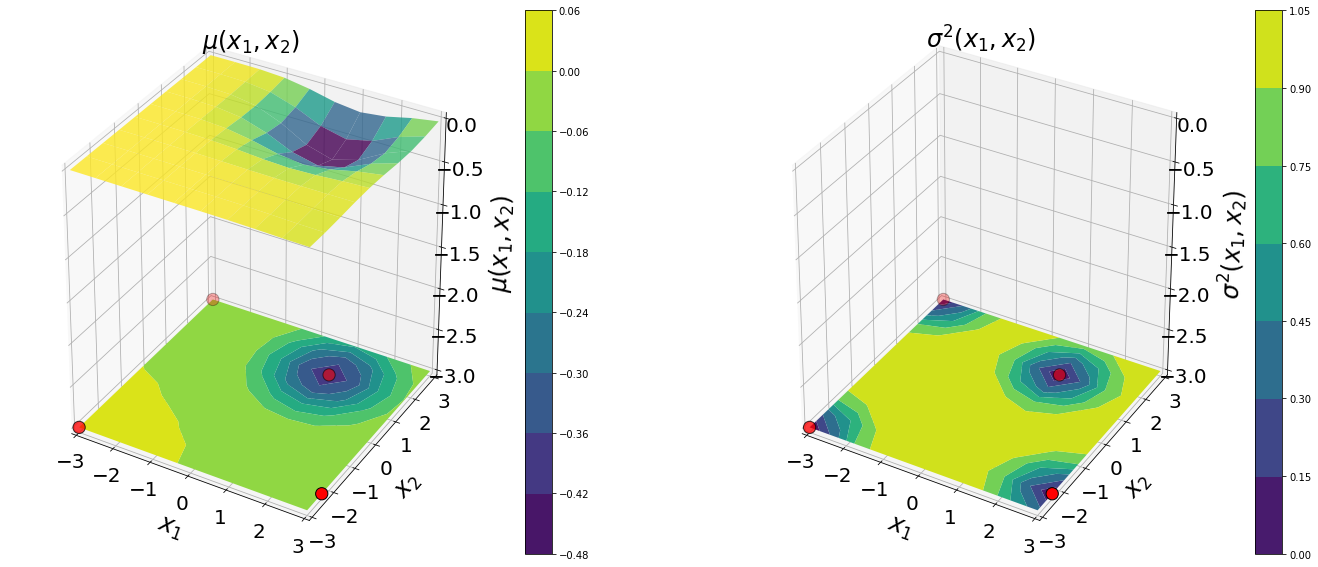

Time needed for plotting=1.9198267459869385
Overall time needed=2.65193772315979
Iterartion=4
Time needed for calculating EI=0.7816317081451416


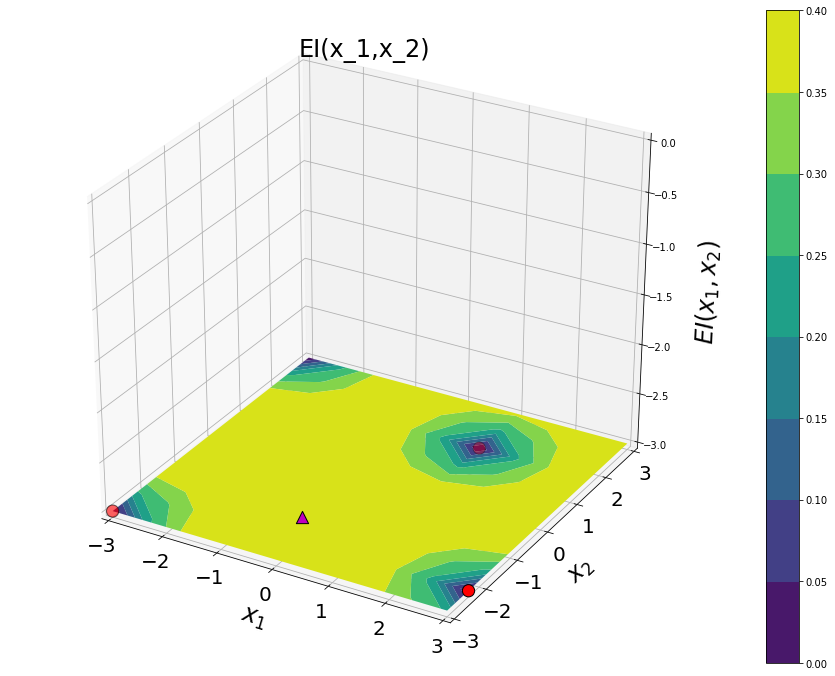

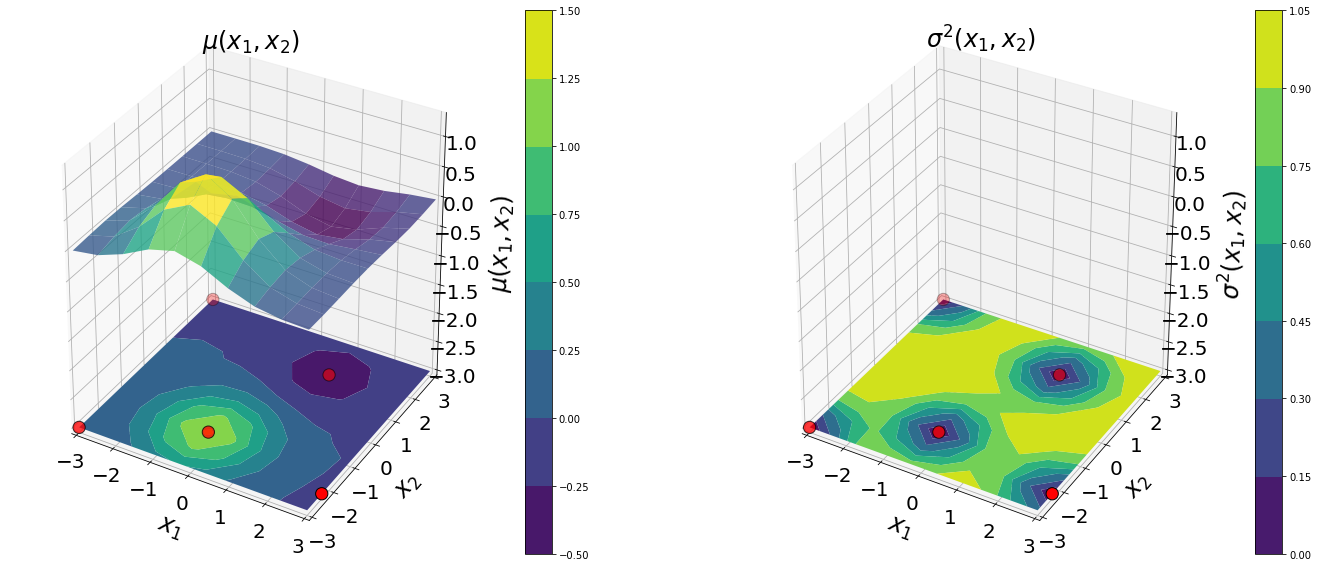

Time needed for plotting=2.041313409805298
Overall time needed=2.823362350463867
Iterartion=5
Time needed for calculating EI=0.7662959098815918


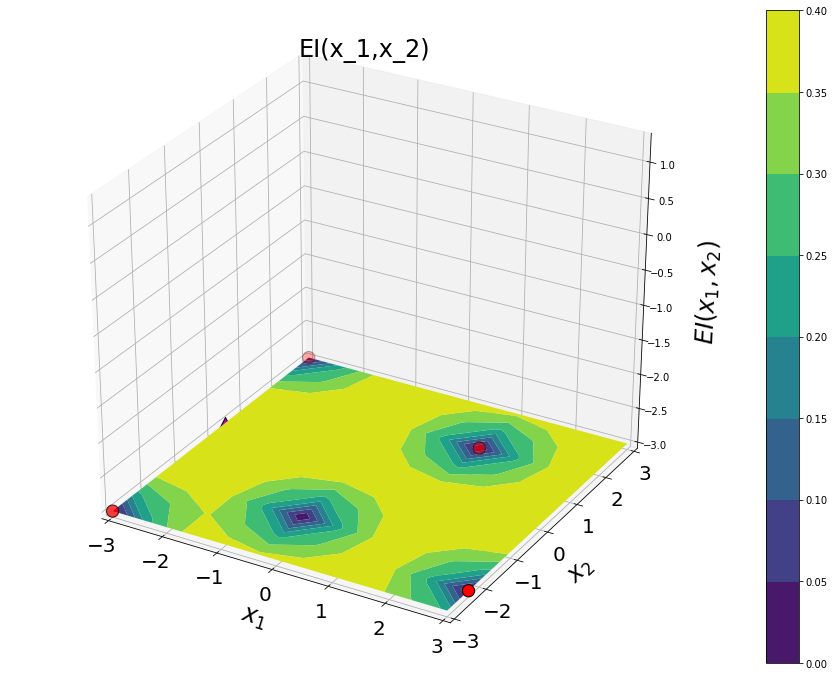

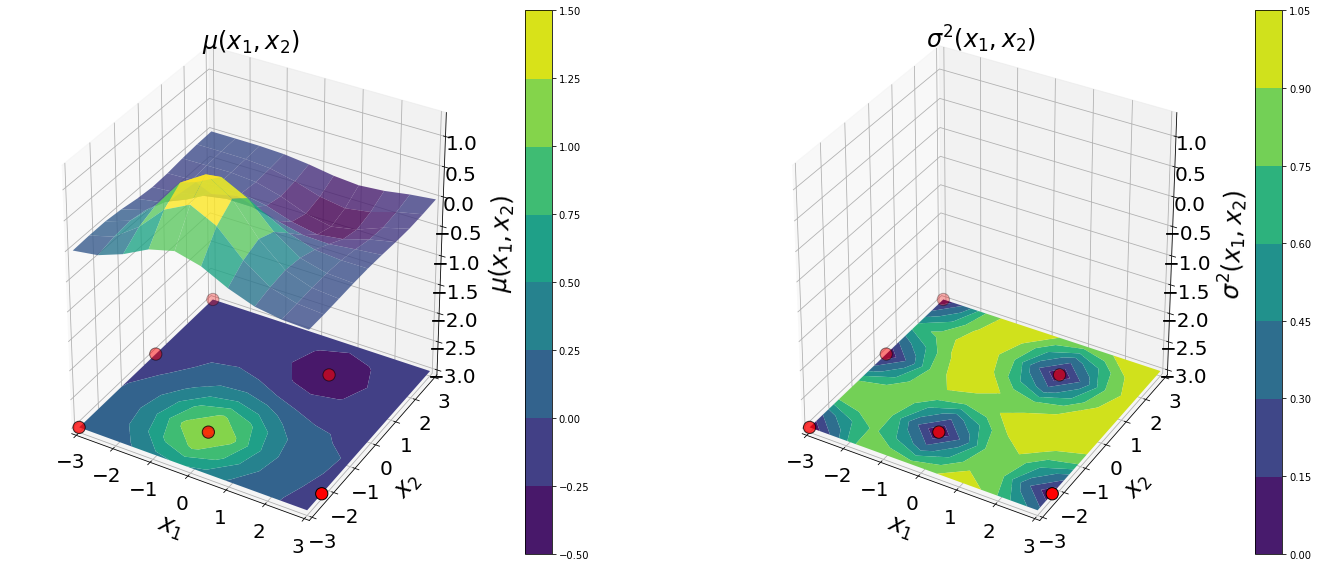

Time needed for plotting=1.9239590167999268
Overall time needed=2.6905386447906494
Iterartion=6
Time needed for calculating EI=0.7339115142822266


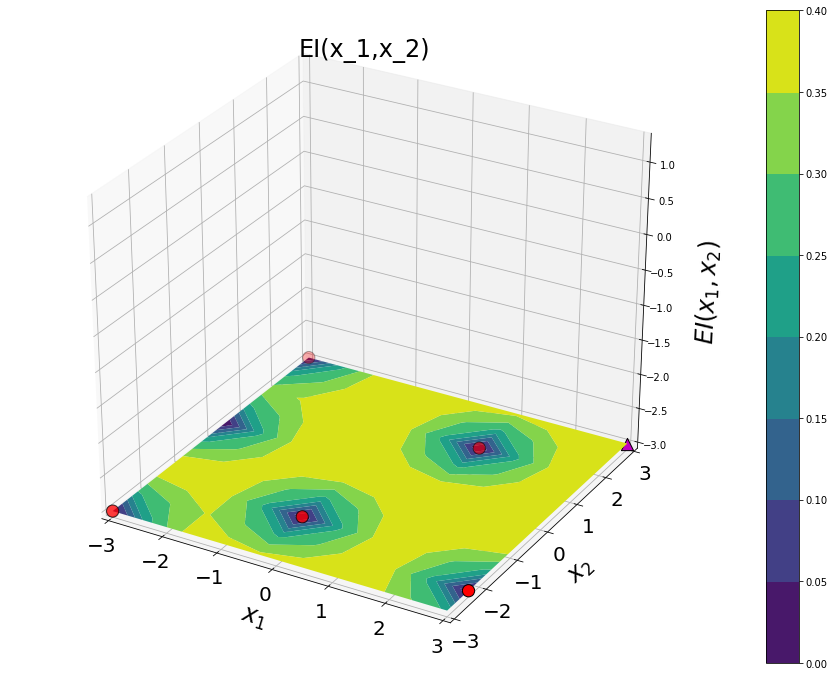

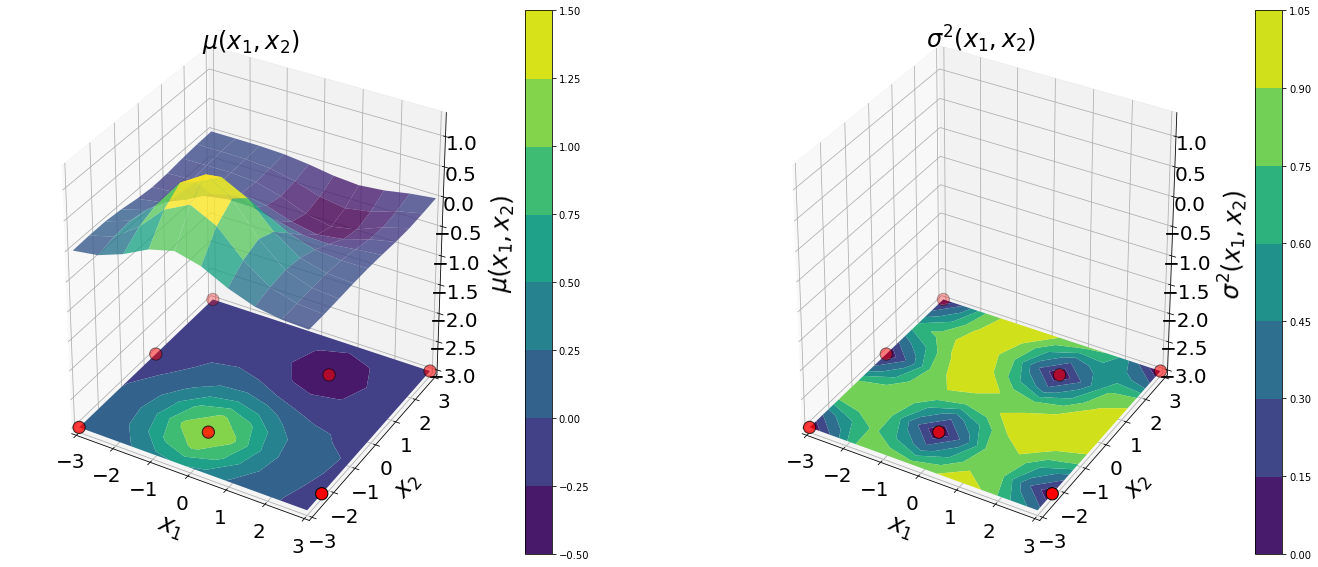

Time needed for plotting=2.0844974517822266
Overall time needed=2.8187530040740967
Iterartion=7
Time needed for calculating EI=0.9736340045928955


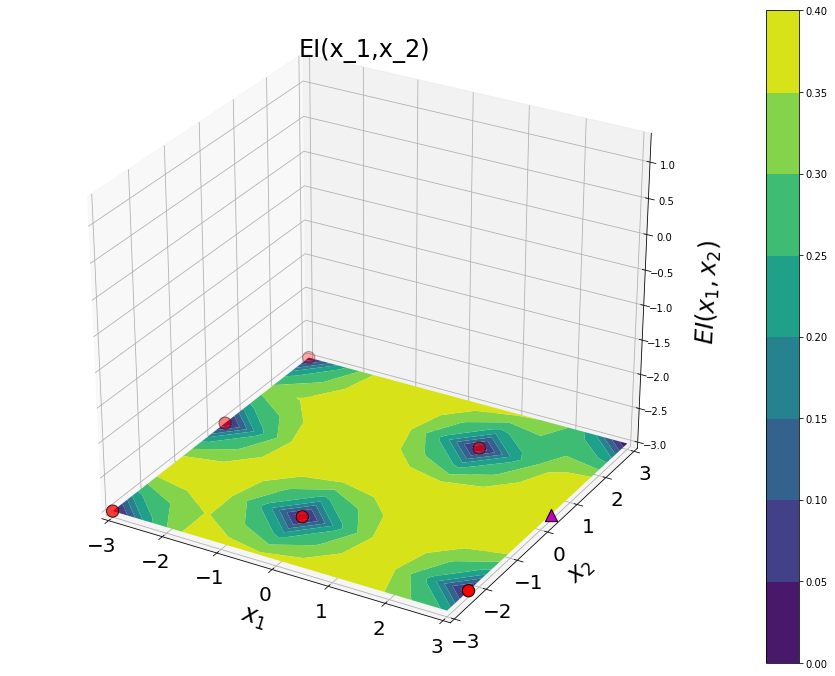

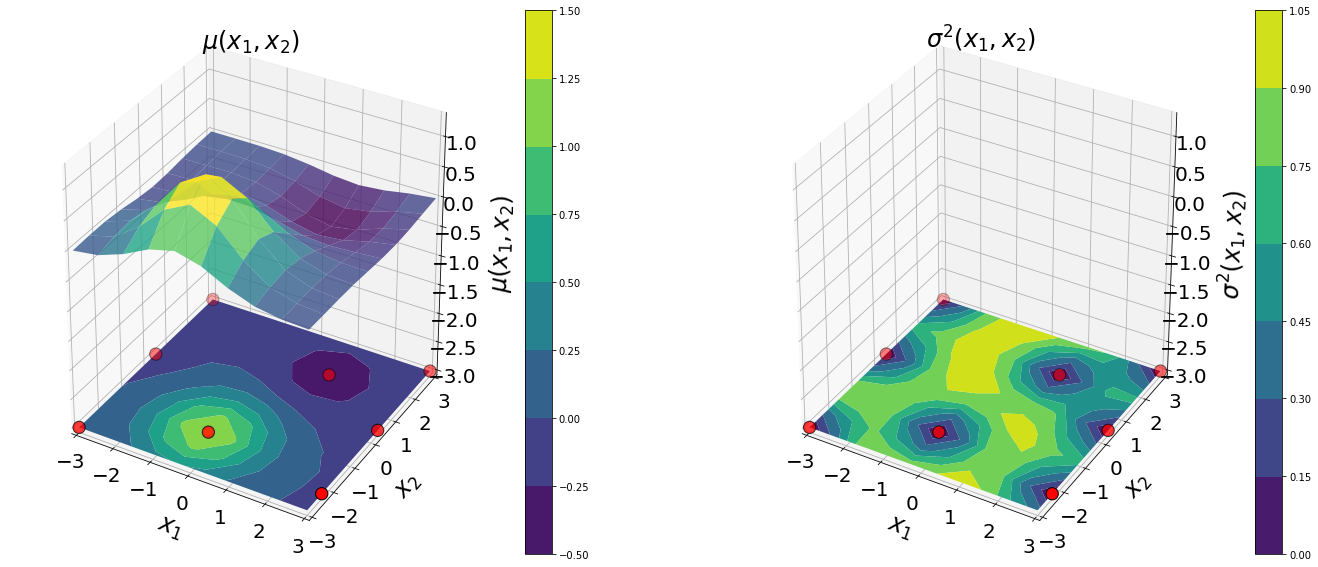

Time needed for plotting=1.8839256763458252
Overall time needed=2.85798716545105
Iterartion=8
Time needed for calculating EI=0.838935375213623


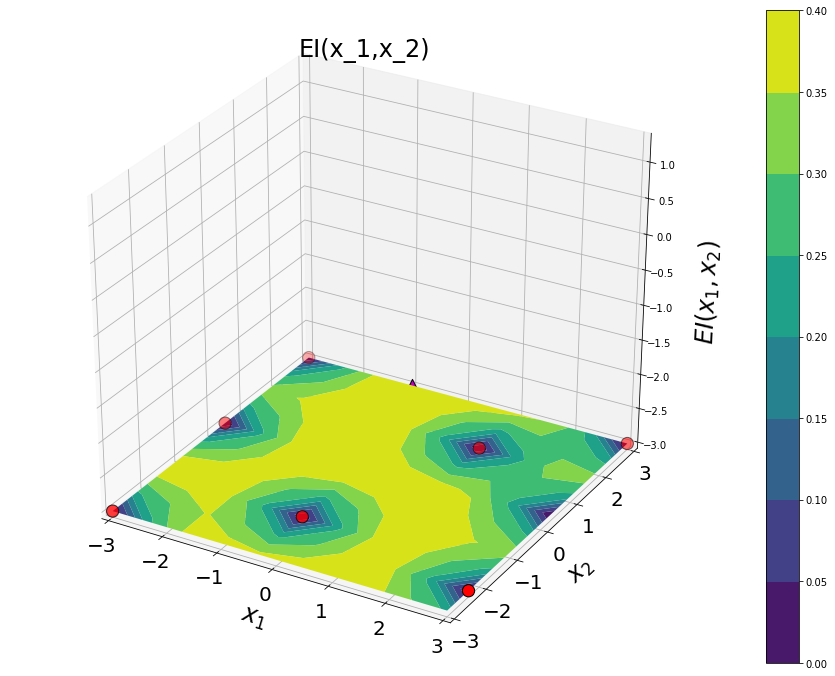

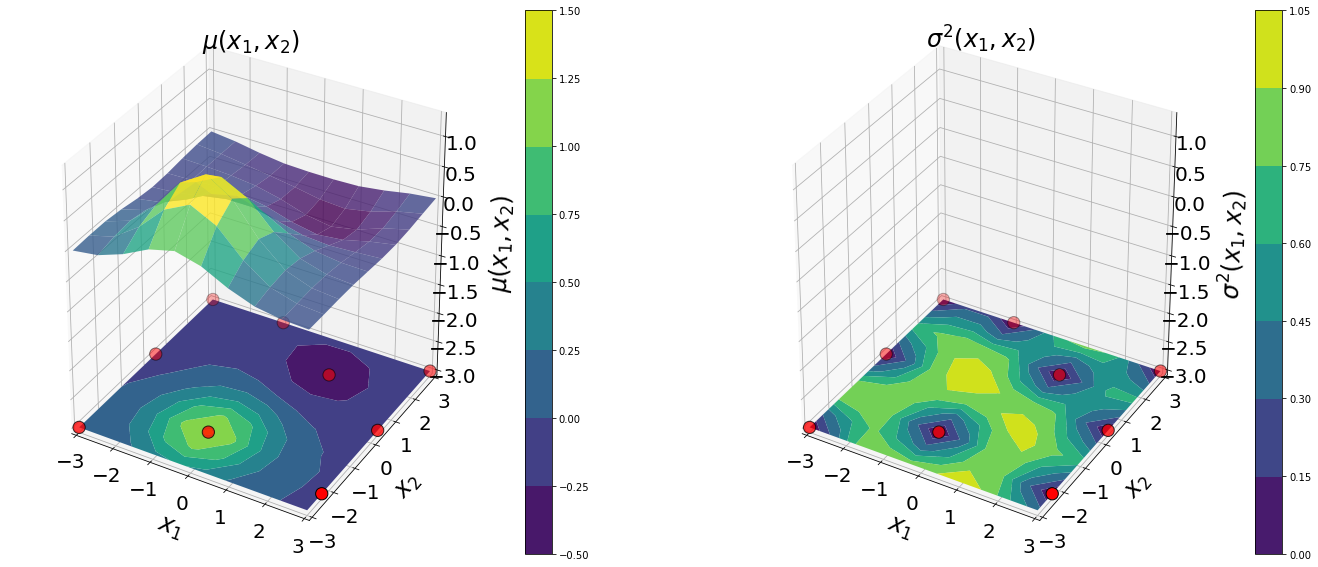

Time needed for plotting=1.8600897789001465
Overall time needed=2.699420213699341
Iterartion=9


Time needed for calculating EI=1.1006815433502197


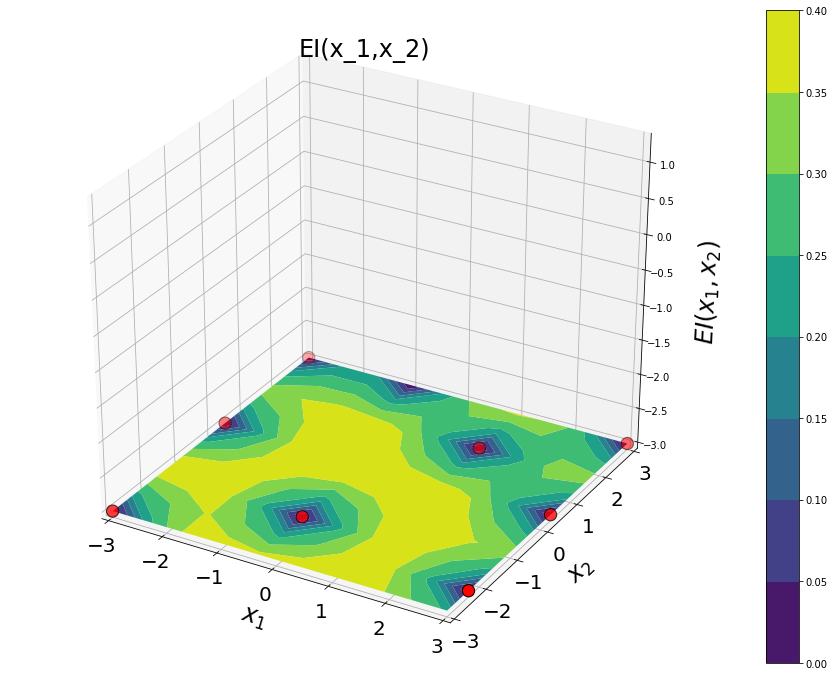

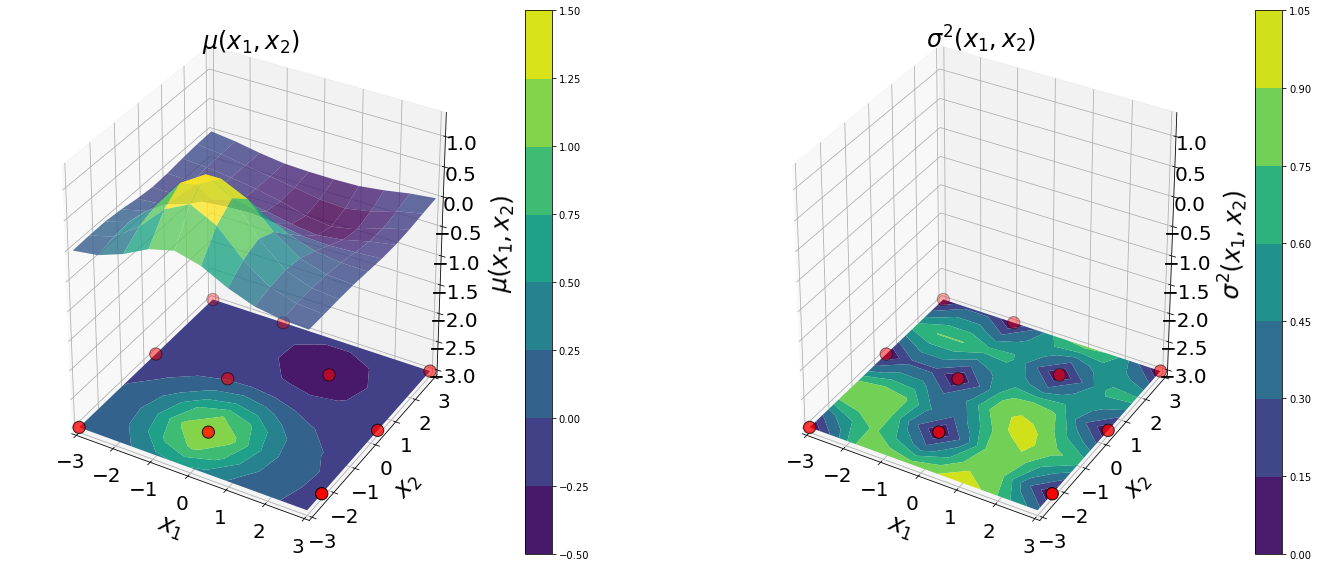

Time needed for plotting=2.011293411254883
Overall time needed=3.1128413677215576


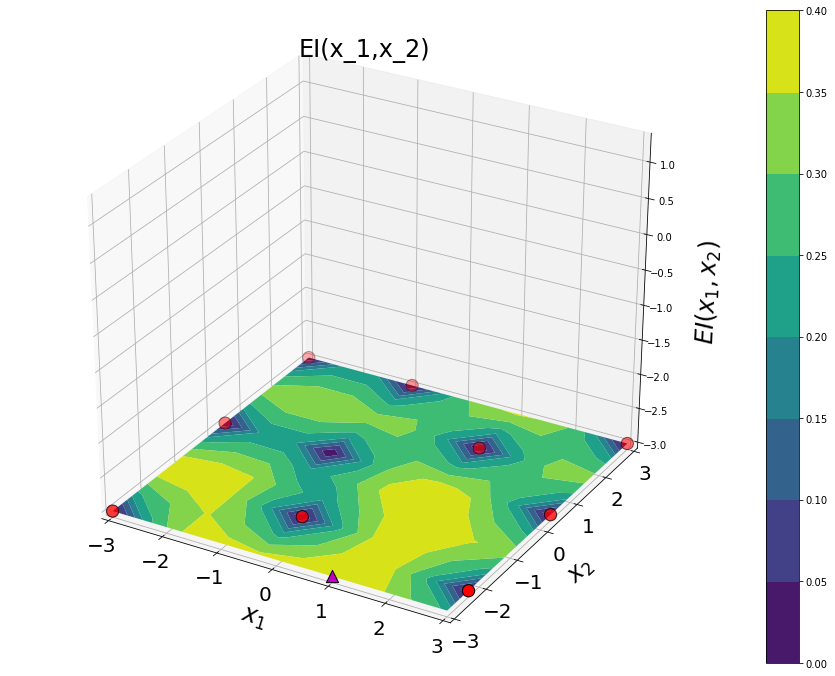

In [11]:
import time
# Set some parameters
lengthscale = 1.
k = gpflow.kernels.RBF(input_dim=2, lengthscales=lengthscale)
N_samples = 9
sigma_n = 0.0

# Draw samples from feature vectors and function by a given index
size = 2
np.random.seed(1991)
index = np.random.choice(range(len(x1)), size=(size,X.ndim), replace=False)
samples = utils.sampleFeature([x1,x2], index)
X1_sample = samples[0]
X2_sample = samples[1]  
X_sample = np.column_stack((X1_sample, X2_sample))
Y_sample = utils.samplefromFunc(f=z, ind=index)
# Compute EI
durations = []
for i in range(N_samples):
    print('Iteration=' + str(i+1) + "/" + str(N_samples))
    start_time = time.time()
        # Estimate model on samples
    m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
    m.likelihood.variance = sigma_n
#     m.kern.lengthscales.trainable = False
#     m.likelihood.variance.trainable = False
    m.compile()
#     print(m)
#     gpflow.train.ScipyOptimizer().minimize(m)
    
    # Predict with model
    mean, var = m.predict_y(X)
    mean_square = mean.reshape(x1_mesh.shape) # Shape: (num,num)
    var_square = var.reshape(x1_mesh.shape) # Shape: (num,num)
    
    # Calculate EI
    ei = acq.get_EI(mean, var, np.max(Y_sample), zeta=0.0)
    ei_square = ei.reshape(x1_mesh.shape)
    elapsed_time = time.time() - start_time
    print("Time needed for calculating EI="+str(elapsed_time))
    # Plot
    start_time2 = time.time()
    utils.plotAcq3D(mean_square, var_square, x1_mesh, x2_mesh, X_sample, bound, True, [ei_square, '$EI(x_1,x_2)$'])
    
    
    
#     fig = plt.figure(figsize=(16, 12))
#     ax = plt.gca()
#     cbar = plt.pcolor(x1, x2, ei_square, edgecolors='k', linewidths=0.5)
# #     cbar = ax.contourf(x1_mesh, x2_mesh, ei_square, zdir='z', offset=offset, cmap=cm.viridis, antialiased=True)
# #     ax.scatter(X1_sample, X2_sample, offset, marker='o',edgecolors='k', color='r', label="Data", s=150)
# #     ax.scatter3D(x1_mesh.reshape(-1)[np.argmax(ei)], x2_mesh.reshape(-1)[np.argmax(ei)], offset, marker='^',edgecolors='k', color='m', label="Data", s=150)
#     fig.colorbar(cbar)
    
#     for r in range(len(X_sample)):
#         plt.plot(X_sample[r][0], X_sample[r][1], marker='.', color='r', linestyle='none', markersize=markersize+20)   
#     ax.plot(x1_mesh.reshape(-1)[np.argmax(ei)], x2_mesh.reshape(-1)[np.argmax(ei)],marker='^', mew=markeredgewidth, 
#             markersize=markersize, color='m')
#     ax.set_title("$EI_(x_1,x_2)$", fontsize=fontsize_title)
#     plt.xticks(fontsize=fontsize_ticks)
#     plt.yticks(fontsize=fontsize_ticks)
#     plt.xlabel('x1', fontsize=fontsize_label)
#     plt.ylabel('x2', fontsize=fontsize_label)
#     ax.set_xlim(-bound-.5, bound+.5)
#     ax.set_ylim(-bound-.5, bound+.5)
    elapsed_time = time.time() - start_time2
    print("Time needed for plotting="+str(elapsed_time))
    # Append new point
    X_sample = np.vstack((X_sample, np.asarray([x1_mesh.reshape(-1)[np.argmax(ei)], x2_mesh.reshape(-1)[np.argmax(ei)]])))
    Y_sample = np.vstack((Y_sample,np.asarray([z.reshape(-1)[np.argmax(ei)]])))
    elapsed_time = time.time() - start_time
    print("Overall time needed="+str(elapsed_time))
    print("----------------------------------------------------")
    durations.append(elapsed_time)

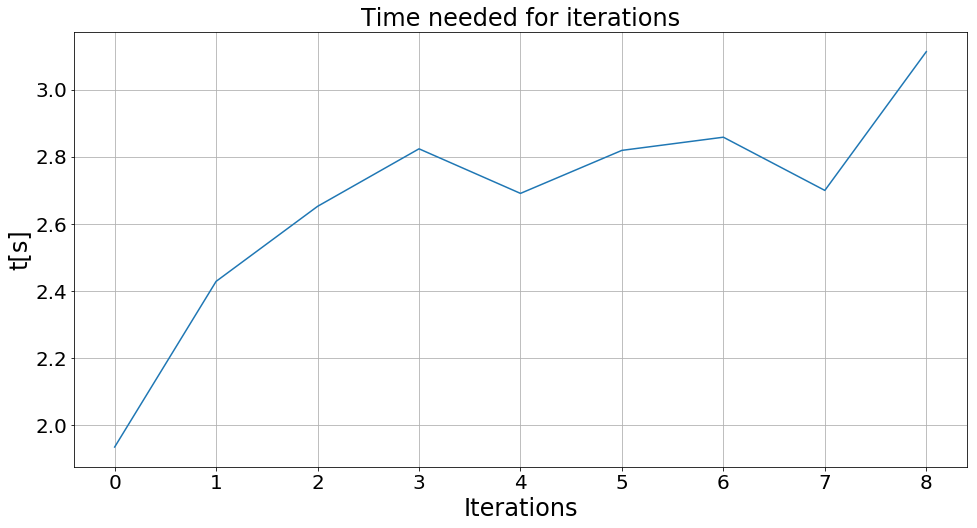

In [12]:
plt.plot(durations)
plt.title("Time needed for iterations", fontsize=fontsize_title)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('Iterations', fontsize=fontsize_label)
plt.ylabel('t[s]', fontsize=fontsize_label)
plt.grid()

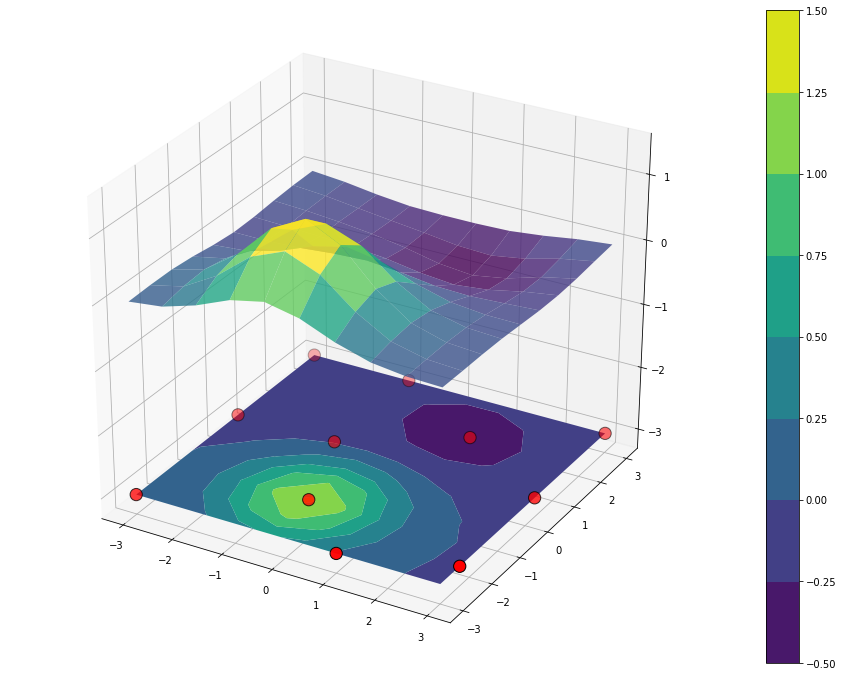

In [86]:
# Plot mean
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection='3d')
cbar = ax.plot_surface(x1_mesh, x2_mesh, mean_square, cmap=cm.viridis, linewidth=0.5, antialiased=True, alpha=0.8)
cbar = ax.contourf(x1_mesh, x2_mesh, mean_square, zdir='z', offset=offset, cmap=cm.viridis, antialiased=True)
ax.scatter3D(X_sample[:,0], X_sample[:,1], offset, marker='o',edgecolors='k', color='r', label="Data", s=150)
fig.colorbar(cbar)

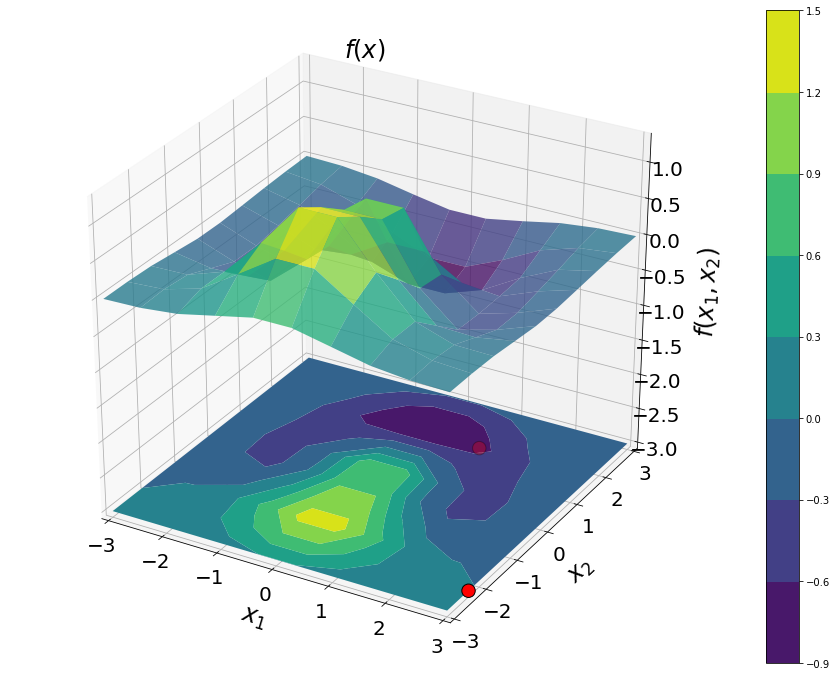

In [71]:
offset = -3.
utils.plot3D(x1_mesh, x2_mesh, z, X1_sample, X2_sample, offset, bound, markersize=180)